In [1]:
from SCFT_functions import *
from DNA_input import *

import numpy as np
import matplotlib.pyplot as plt

Using cupy


In [2]:
base_pairs = 2.25e6 # 2MB
l_c = base_pairs * 0.34 #nm
l_p = 50 # nm
n_seg = int(base_pairs/50)
print("nseg=",n_seg)
print("lc=",l_c)

v_tot = 25**3
v_chain = pow(1/50, 2) * 3.14 * n_seg
print("3d=",v_chain/v_tot)


nseg= 45000
lc= 765000.0
3d= 0.0036172800000000005


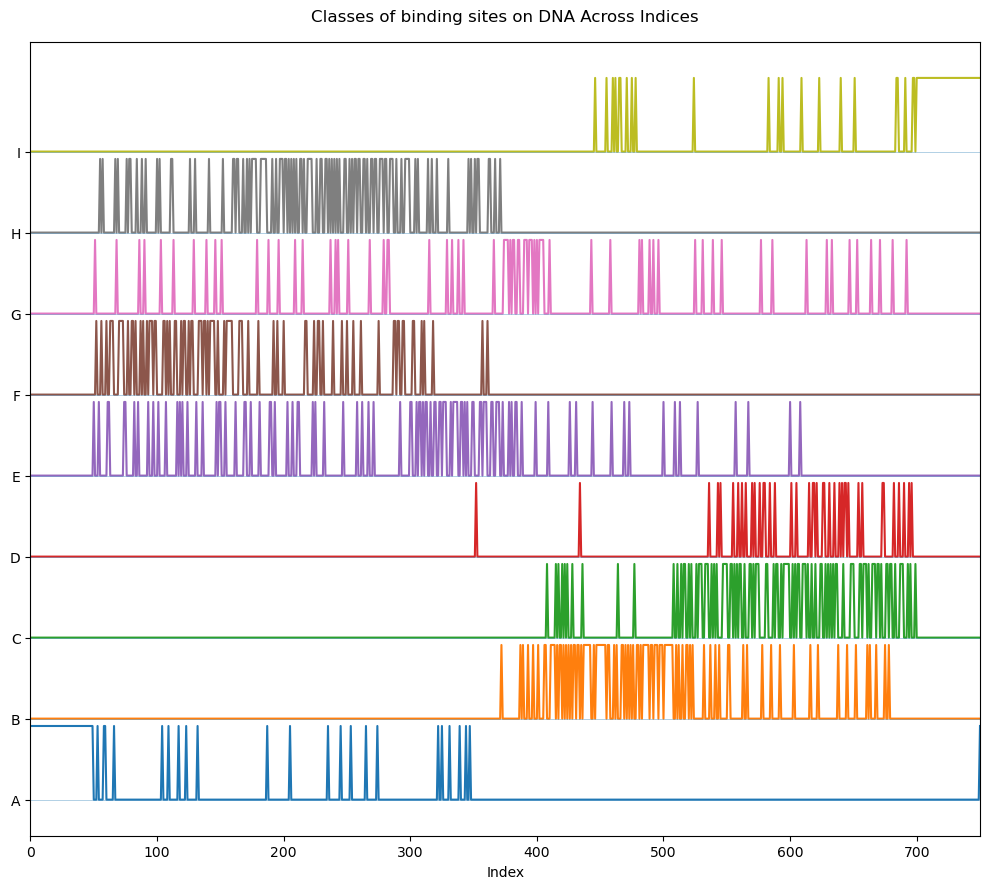

In [3]:
ns = 750
chain_interaction_binary = IMR90_data(ns)

In [19]:
N = 1
Nseg = 100

nx = ny = nz = 32
initial_qsr = np.ones((nx, ny, nz))
L = 30 #dimension of the box

chi_pp = 1.7*np.ones((chain_interaction_binary.shape[0],chain_interaction_binary.shape[0]))
chi_ps = 1.7*np.ones(chain_interaction_binary.shape[0])

polymer = Scft(
    N = N,
    Lx=L, Ly=L,
    phibar=0.15, # volume fraction of polymer
    l_p=np.sqrt(N),
    n_seg=Nseg, # contour length of polymer normalized from 0-1
    nx=nx, ny=ny,
    ns=ns,
    iterations=10000,
    error_tol=1e-12,
    chain_interaction=chain_interaction_binary,
    self_avoiding=0,
    initial_qsr=initial_qsr / np.mean(initial_qsr),
    mixing_rate=0.05,
    chi_polymer_block = chi_pp,
    chi_polymer_s = chi_ps,
    PB = 2,
    close_boundary=True,
    D3 = True,
    Lz = L,
    nz = nz
)

In [20]:
wsr, qsr_initial, qsr_d_initial, diff = initialization(polymer)

In [21]:
#%prun -D profile.pstat
#polymer.iterations = 2
#polymer.mixing_rate = 0.01
wsr, phi, phi_blocks, qsr_initial, qsr_d_initial, diff = scft_loop(polymer, wsr, qsr_initial, qsr_d_initial, diff)

100%|██████████| 10000/10000 [2:59:40<00:00,  1.08s/it] 


In [17]:
def save_np(wsr, phi, phi_blocks, qsr_initial, qsr_d_initial, diff):
    arrs = {
            "wsr": to_numpy(wsr),
            "phi": to_numpy(phi),
            "phi_blocks": to_numpy(phi_blocks),
            "qsr_initial": to_numpy(qsr_initial),
            "qsr_d_initial": to_numpy(qsr_d_initial),
            "diff": to_numpy(diff),
        }

    np.savez("polymer3d.npz", arrs=arrs)
    return

save_np(wsr, phi, phi_blocks, qsr_initial, qsr_d_initial, diff)


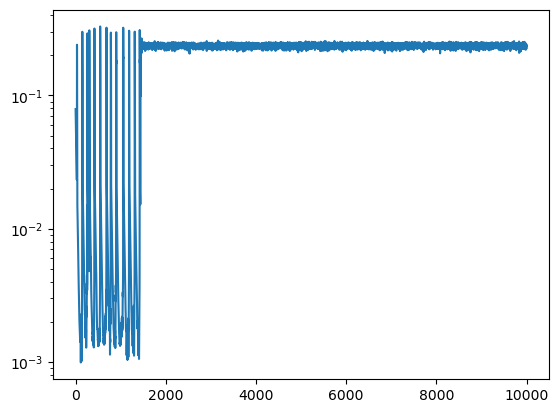

In [22]:
plt.plot(diff)
plt.yscale('log')

In [23]:
import matplotlib.pyplot as plt
import numpy as np
from skimage import measure
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def plot_multi_isosurface(densities, threshold_ratio=0.8, alpha=0.6, colormap='tab10'):
    """
    Plot isosurfaces for multiple 3D density arrays on the same axes.

    Parameters:
    - densities: list or array of shape (m, nx, ny, nz), where each element is a 3D density grid
    - threshold_ratio: float between 0 and 1; isosurface at this fraction of each component's max
    - alpha: float for surface transparency
    - colormap: name of a matplotlib colormap for distinct colors
    """
    # Ensure list of 3D arrays
    comps = list(densities)
    m = len(comps)
    cmap = plt.cm.get_cmap(colormap, m)

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    for i, density in enumerate(comps):
        level = threshold_ratio * density.max()
        verts, faces, normals, values = measure.marching_cubes(density, level=level)
        mesh = Poly3DCollection(verts[faces], alpha=alpha)
        mesh.set_facecolor(cmap(i))
        ax.add_collection3d(mesh)

    # Set axes limits based on the first component
    nx, ny, nz = comps[0].shape
    ax.set_xlim(0, nx)
    ax.set_ylim(0, ny)
    ax.set_zlim(0, nz)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.tight_layout()
    plt.show()

    return

C:\Users\19162\AppData\Local\Temp\ipykernel_34756\582000932.py:19: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



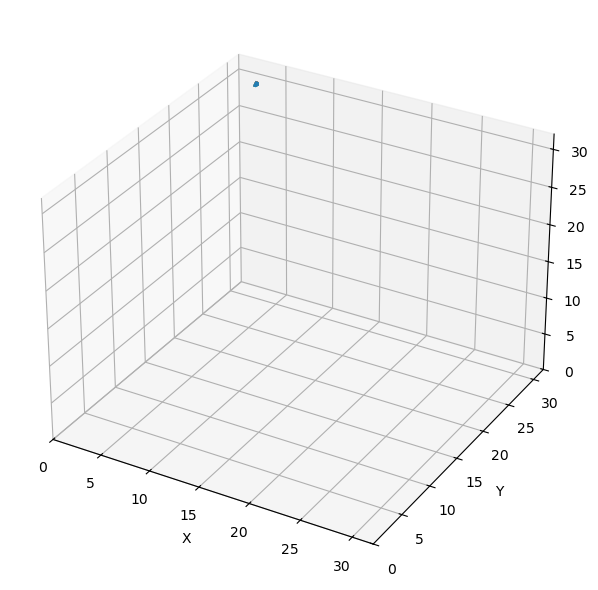

In [24]:
plot_multi_isosurface(to_numpy(phi_blocks), threshold_ratio=0.85)

In [12]:
import plotly.graph_objects as go

def plot_isosurfaces(
    density,
    top_fraction: float = 0.10,
    spacing=(1.0, 1.0, 1.0),
    component_names=None,
    save_html_path=None,
):
    vol = to_numpy(density)
    assert vol.ndim == 4, f"Expected (m, nx, ny, nz), got shape {vol.shape}"
    m, nx, ny, nz = vol.shape
    sx, sy, sz = spacing

    if component_names is None:
        component_names = [f"component {i}" for i in range(m)]
    else:
        assert len(component_names) == m, "component_names must match m"

    fig = go.Figure()

    for i in range(m):
        field = vol[i].astype(np.float64, copy=False)
        flat = field.ravel()
        nonzero = flat[flat > 0]
        base = nonzero if nonzero.size > 0 else flat
        if base.size == 0:
            continue

        iso_level = float(np.quantile(base, 1.0 - top_fraction))

        # Marching cubes at the chosen iso-level
        try:
            verts, faces, normals, values = measure.marching_cubes(
                volume=field, level=iso_level, spacing=(sx, sy, sz)
            )
        except TypeError:
            verts, faces, normals, values = measure.marching_cubes_lewiner(
                field, level=iso_level, spacing=(sx, sy, sz)
            )

        if verts.size == 0 or faces.size == 0:
            continue

        mesh = go.Mesh3d(
            x=verts[:, 0], y=verts[:, 1], z=verts[:, 2],
            i=faces[:, 0], j=faces[:, 1], k=faces[:, 2],
            name=component_names[i],
            opacity=0.5,
            flatshading=True,
            showscale=False,
        )
        fig.add_trace(mesh)

    fig.update_layout(
        title="Polymer components: densest-region iso-surfaces",
        scene=dict(xaxis_title="x", yaxis_title="y", zaxis_title="z", aspectmode="data"),
        showlegend=True,
    )

    if save_html_path is not None:
        fig.write_html(save_html_path, include_plotlyjs="cdn")
        return save_html_path
    return fig

In [15]:
plot_isosurfaces(
    to_numpy(phi_blocks),                 # shape (m, nx, ny, nz)
    top_fraction=0.05,       # densest fraction to enclose as an iso-surface
    spacing=(polymer.dx, polymer.dy, polymer.dz),    # voxel spacing for proper aspect ratio
    component_names=None,    # optional list of names per component
    save_html_path='isosurface_demo.html',     # optional: path to save interactive HTML
)

'isosurface_demo.html'

In [14]:
qsr_decay = np.mean(qsr, axis = (1,2,3))
plt.plot(to_numpy(qsr_decay))
plt.yscale('log')

NameError: name 'qsr' is not defined

In [23]:
del qsr


NameError: name 'qsr' is not defined

In [24]:
del qsr_d

In [25]:
del phi